# Text Similarity Using GloVe

## 1. Loading and Preprocessing Text 

In [1]:
documents = [
    'He was in need of some cash.',
    'He withdrew money from the bank.',
    'She bought groceries from market.',
    "He went by the river bank and slept under a tree.",
    'The painter painted a beautiful picture of the bank',
    'He slept by the bank.',
    'People were protesting infront of the bank.',
    'He was studying at the school.'
]

In [2]:
import re
def preprocess(docs:list):
    
    res = []
    for i in docs:
        i = i.lower()
        res.append(re.sub(r'[^\w\s]', ' ', i)) # Remove punctuations

    return res

In [3]:
documents = preprocess(documents)
documents

['he was in need of some cash ',
 'he withdrew money from the bank ',
 'she bought groceries from market ',
 'he went by the river bank and slept under a tree ',
 'the painter painted a beautiful picture of the bank',
 'he slept by the bank ',
 'people were protesting infront of the bank ',
 'he was studying at the school ']

## 2. Exploring Word Vectors with GloVe

In [4]:
import torch
import torchtext.vocab as vocab
import torchtext

### 2.1 Loading word vectors

In [5]:
glove = vocab.GloVe(name='6B', dim=100)

print('Loaded {} words'.format(len(glove.itos)))

Loaded 400000 words




The returned GloVe object includes attributes:

- `stoi` string-to-index returns a dictionary of words to indexes
- `itos` index-to-string returns an array of words by index
- `vectors` returns the actual vectors. To get a word vector get the index to get the vector:



In [6]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]


### 2.2 Finding closest vectors

Going from word → vector is easy enough, but to go from vector → word takes more work. Here I'm (naively) calculating the distance for each word in the vocabulary, and sorting based on that distance:

In [7]:
def closest(vec, n=5):
    """
    Find the closest words for a given vector
    """
    all_dists = [(w, torch.dist(vec, get_word(w))) for w in glove.itos]
    return sorted(all_dists, key=lambda t: t[1])[:n]

In [8]:
def get_closest(vec,k=5,d= -1):
    cos = torch.nn.CosineSimilarity(dim = d)
    out = []
    for word in glove.itos:
        out.append(cos(get_word(vec),get_word(word)))  
    out = torch.stack(out)  
    word = [glove.itos[i] for i in torch.topk(out,k).indices]
    value = [i for i in torch.topk(out,k).values]
    return word, value

In [9]:
word, value = get_closest('google',k=5,d= -1)

In [10]:
for i in range(5):
    print(f'{word[i]}-->{value[i]:.4f}')

google-->1.0000
yahoo-->0.8637
microsoft-->0.8104
web-->0.7630
aol-->0.7572


In [11]:
def print_tuples(tuples):
    for tuple in tuples:
        print(f'({tuple[1]:.4f}) {tuple[0]}')

In [12]:
print_tuples(closest(get_word('google')))

(0.0000) google
(3.0772) yahoo
(3.8836) microsoft
(4.1048) web
(4.1082) aol


### 2.3 Word analogies with vector arithmetic

In [13]:
# In the form w1 : w2 :: w3 : ?
def analogy(w1, w2, w3, n=5, filter_given=True):
    print(f'[{w1} : {w2} :: {w3} : ?]')
   
    # w2 - w1 + w3 = w4
    closest_words = closest(get_word(w2) - get_word(w1) + get_word(w3))
    
    # Optionally filter out given words
    if filter_given:
        closest_words = [t for t in closest_words if t[0] not in [w1, w2, w3]]
        
    print_tuples(closest_words[:n])

In [14]:
analogy('king', 'man', 'queen')

[king : man :: queen : ?]
(4.0811) woman
(4.6916) girl
(5.2703) she
(5.2788) teenager


In [15]:
analogy('man','doctor','woman')

[man : doctor :: woman : ?]
(4.2283) nurse
(4.7054) physician
(4.9699) dentist


In [16]:
analogy('man','engineer','woman')

[man : engineer :: woman : ?]
(4.6912) technician
(5.2088) educator
(5.2372) contractor
(5.2676) surgeon


### 2.4 Sentence Embeddings

In [17]:
tokenizer = torchtext.data.get_tokenizer('basic_english')  

In [18]:
sent1 = documents[0]
sent2 = documents[2]

In [19]:
documents[0]

'he was in need of some cash '

In [20]:
cos = torch.nn.CosineSimilarity()

In [21]:
x1 = []
for word in sent1.split():
    x1.append(get_word(word))
x1 = torch.stack(x1)

In [22]:
x2 = []
for word in sent2.split():
    x2.append(get_word(word))
x2 = torch.stack(x2)

In [23]:
x1.shape,x2.shape

(torch.Size([7, 100]), torch.Size([5, 100]))

Here we get scores with shape : *(num_tokens)* x *(embedding)*.<br>
Since we need a single score for entire sequence, a quick fix can be taking mean along embbeding dimension.<br><br>
For other methods refer : https://www.baeldung.com/cs/sentence-vectors-word2vec

In [24]:
y1 = torch.mean(x1,1)
y2 = torch.mean(x2,1)

Applying padding since sequence are not of same lenghts.

In [25]:
pad = (0,(len(x2)-len(x1)))
y1 = torch.nn.functional.pad(y1, pad, "constant", 0)

In [26]:
y1.shape

torch.Size([5])

In [27]:
cos = torch.nn.CosineSimilarity(dim=-1)
cos(y1,y2)

tensor(0.0122)

In [28]:
def scores(docs:list):
    temp = []
    for i in range(0,len(docs)):
        for j in range(0,len(docs)):
            x1 = torch.stack([get_word(word) for word in docs[i].split()]).mean(dim=1) 
            x2 = torch.stack([get_word(word) for word in docs[j].split()]).mean(dim=1)
            if len(x2) > len(x1):
                pad = (0,len(x2)-len(x1))
                x1 = torch.nn.functional.pad(x1, pad, "constant", 0)
            else:
                pad = (0,len(x1)-len(x2))
                x2 = torch.nn.functional.pad(x2, pad, "constant", 0)
            
            cos = torch.nn.CosineSimilarity(dim=-1)
            temp.append(cos(x1,x2))
            score = torch.stack(temp)
    return score

In [29]:
score = scores(documents).reshape(len(documents),len(documents)).numpy()

In [30]:
score.shape

(8, 8)

### 2.5 Plotting results

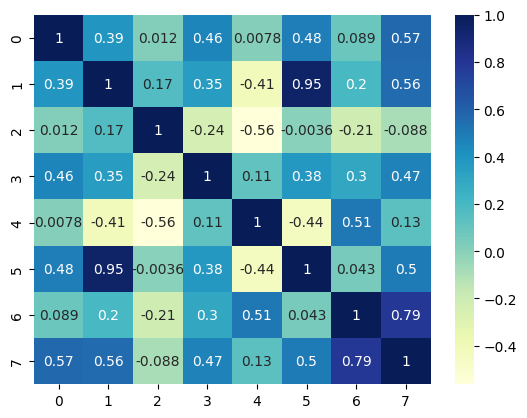

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(score, annot=True, cmap="YlGnBu")
plt.show()

Conclusion : Results seem to quite bad with averaging the mean across the embedding dimension, other methods can be used to imporve the results. 